# Training and testing on EEG summary-statistics dataset

In [31]:
%matplotlib widget
# widget requires ipympl

# Standard library
import importlib
import dataclasses
from dataclasses import dataclass
import time
from os import path, makedirs

# Nonstandard packages
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.optim import Adam, SGD, Rprop

from sklearn.model_selection import KFold

# Custom files
import static_nets
import constr_casc
import performance_metrics as pm

plt.ioff(); # Avoids plot-duplicates in Jupyter when cell execution finishes

metaseed = 187598710957 # Seed for generating seeds

### Loss function

In [32]:
bceLogitLossMean = nn.BCEWithLogitsLoss(reduction='mean')
# Applies sigmoid internally. More stable than Sigmoid + BCELoss.

def loss_accuracy(pred_logits, y):
  loss = bceLogitLossMean(pred_logits, y)
  pred_class = F.sigmoid(pred_logits).round()
  accuracy = torch.mean(pred_class == y, dtype=torch.float32)
  return loss.item(), accuracy.item()

# Further metrics in performance_metrics.py

### Load pre-processed data

In [33]:
class TableDataset(Dataset):
  def __init__(self, data, name, outdir='./results/'):
    self.data = data
    self.n_features = data.shape[1] - 1 # Last column is target
    self.n_subjects = data.shape[0] // 6 # 6 samples per subject

    # Keep data in order with n_subjects splits, to achieve
    # leave-one-subject-out cross validation
    self.kf = KFold(n_splits=self.n_subjects, shuffle=False)

    self.perfs = {} # KFoldPerformance for each model
    self.eval_epochs = {} # Epoch to evaluate each model at

    # Try load existing results (avoids having to re-run all models).
    self.name = name
    self.outdir = outdir
    self._outfile = path.join(outdir, f'perf_{name}.csv')
    try:
      self.perf_table = pd.read_csv(self._outfile, index_col='model')
    except FileNotFoundError:
      self.perf_table = pd.DataFrame(
      index = pd.CategoricalIndex(data=[], categories=[], name='model'),
      columns=[
        'n_runs', 'n_folds', 'epochs', 'time', 'size', 'train-acc', 'acc',
        'prec','sens', 'spec', 'f1'
        ])
  
  def __len__(self):
    return self.data.size(0)
  
  def __getitem__(self, idx):
    return (self.data[idx, :-1], self.data[idx, -1:])
    # idx is a list of indices, or a single index.
    # ':' after -1 preserves tensor dimension
  
  def split(self): #KFold (train,test) indices
    return self.kf.split(self.data)

  def save(self):
    makedirs(self.outdir, exist_ok=True)
    self.perf_table.to_csv(self._outfile, index=True)

  def recompute_model_perfs(self, m_ids=None):
    # Compute/store perfomance summary for each model.
    # Assumes each m_id has a KFoldPerformance in self.perfs.
    # Epoch defaults to last epoch if not in m_epoch_dict, or > last epoch.
    if m_ids is None:
      m_ids = self.perfs.keys()

    for m_id in m_ids:
      if m_id not in self.perfs:
        print(f"Warning: {self.name} dataset asked to recompute performance for model {m_id}, but no KFoldPerformance is stored for this model")
        continue
      perf = self.perfs[m_id]
      tm = perf.train_metrics

      #Assumes tm.epoch is ascending. Argmax returns first index.
      max_epoch = tm.epoch[-1].item()
      eval_epoch = min(self.eval_epochs.get(m_id, max_epoch), max_epoch)
      record_idx = torch.argmax((tm.epoch >= eval_epoch).to(dtype=torch.int64))

      testMet = pm.PredictionMetrics.from_confusion(perf.confusions[record_idx,:,:])

      self.perf_table.loc[m_id] = {
        'n_runs': perf.n_runs,
        'n_folds': perf.n_folds,
        'epochs': eval_epoch,
        'time': tm.time[record_idx].item(),
        'size': (tm.hidden_neurons[record_idx].item() if 'hidden_neurons' in tm.names else None), # Only cascade networks record size, otherwise blank
        'train-acc': tm.train_accuracy[record_idx].item(),
        'acc': testMet.accuracy,
        'prec': testMet.precision,
        'sens': testMet.sensitivity,
        'spec': testMet.specificity,
        'f1': testMet.f1
      }

    self.save()

In [34]:
# 14 brain regions * 15 stats -> 210 features (or subset thereof)
Xy_all = torch.load('./data/features_processed_all.pt') #float32; see data_prep.ipynb
eeg_all = TableDataset(Xy_all, 'all')

Xy_no_outliers = torch.load('./data/features_processed_no_outliers.pt')
eeg_no_outliers = TableDataset(Xy_no_outliers, 'no_outliers')

Xy_f7 = torch.load('./data/features_processed_f7.pt')
eeg_f7 = TableDataset(Xy_f7, 'f7')

#Xy_f3 = torch.load('./data/features_processed_f3.pt')
#eeg_f3 = TableDataset(Xy_f3, 'f3')

#Xy_rahman = torch.load('./data/features_processed_rahman.pt')
#eeg_rahman = TableDataset(Xy_rahman, 'rahman')

In [35]:
# Manually-chosen epoch at which to evaluate each model,
# based on output graphs below (after running for each dataset)
# This is so we can pick the best performance for each model,
# (in case it declines) and compare the time taken to achieve.

eeg_f7.eval_epochs.update({
  'linGDlr0.1': 500,
  #'linSGDlr0.01bs12': 390,
  #'linAdam': 500,
  'linAdamLr0.001bs12': 670,
  #'linAdamlr0.01': 400,
  'linRprop': 75,
  #'h30GD': 800,
  'h30GDlr0.1': 1000,
  #'h30GDlr0.001bs12': 800,
  'h30AdamBs12': 500,
  #'h30AdamLr0.01': 100,
  'hid30Rprop': 110
})

eeg_no_outliers.eval_epochs.update({
  'linGDlr0.1': 150,
  #'linSGDlr0.01bs12': 100,
  #'linAdam': 499,
  'linAdamLr0.001bs12': 650,
  #'linAdamlr0.01': 250,
  'linRprop': 50,
  #'h30GD': 400,
  'h30GDlr0.1': 300,
  #'h30GDlr0.001bs12': 400
  'h30AdamBs12': 1400,
  'hid30Rprop': 50
})
# best models: linGDlr0.1, linRprop (best, and super fast), all h30 variants but particularly h30GDlr0.1
# small batch improved linAdam considerably, at no time cost.

eeg_all.eval_epochs.update({
  'linGDlr0.1': 140,
  #'linSGDlr0.01bs12': #80,
  ##'linAdam': 500,
  'linAdamLr0.001bs12': 90,
  ##'linAdamlr0.01': 400,
  'linRprop': 100,
  #'h30GD': -1,
  'h30GDlr0.1': 330,
  ##'h30GDlr0.001bs12': 800,
  'h30AdamBs12': 130,
  ##'h30AdamLr0.01': 50,
  'hid30Rprop': 50,
})

### Train standard feedforward networks

In [36]:
# Model description
@dataclass
class StaticModel:
  desc: str

  initNet: nn.Module # will be passed (n_features, **net_kw)
  net_kw: dict
  initOpt: torch.optim.Optimizer # passed (net.parameters(), **opt_kw)
  opt_kw: dict
  #initScheduler: torch.optim.lr_scheduler._LRScheduler = None
  #scheduler_kwargs: dict = None

  batch_size: int = 1000 # >>> n_samples, i.e. no batching by default
  n_epochs: int = 1001 # Required epochs varies with e.g. network size
  
  performance: pm.KFoldPerformance = None

  def __str__(self):
    return f"{self.desc} ({', '.join([f'{k}={v}' for k,v in self.opt_kw.items()])})"

  def clone(self, **kwargs):
    return dataclasses.replace(self,**kwargs)

In [37]:
# Define a set of static-architecture models to test
# (network architecture, optimiser, hyperparameters)
importlib.reload(static_nets)

bc = static_nets.BinaryClassifier # defaults to a no-hidden-layer network.
rprop_kw = {'etas':(0.5, 1.2), 'step_sizes':(1e-06, 50)}

# Logistic regression base models
linGD = StaticModel("Linear Full GD", bc, {}, SGD, {"lr": 0.01}, n_epochs=1600)
linAdam = StaticModel("Linear Adam", bc, {}, Adam, {"lr": 0.001}, n_epochs=1600)
linRprop = StaticModel("Linear Rprop", bc, {}, Rprop, {'lr':0.01, **rprop_kw}, n_epochs=500)
# f7 only needs 800 epochs for logistic models and 1000 for hid30; trying more for eeg_all

# Single hidden layer with 30 units, as in Brain Melody Informatics paper.
hid30 = lambda n_feat, **kwargs: bc(n_feat, hidden_sizes=[30], **kwargs)
hid30GD = StaticModel("HL30 ReLU GD", hid30, {}, SGD, {"lr": 0.01}, n_epochs=2000)

# Comment-out variants from the list to avoid running them.

# Hyperparameter variants to run
staticModels = { #id: StaticModel
  # Logistic regression (i.e. no hidden layers)
  'linGDlr0.1': linGD.clone(opt_kw={"lr": 0.1}),
  'linAdamLr0.001bs12': linAdam.clone(batch_size=12, desc="Linear Adam (batch=12)"),
  'linRprop': linRprop,
  # H30 (like Brain Melody Informatics paper)
  'h30GDlr0.1': hid30GD.clone(opt_kw={"lr": 0.1}),
  'h30AdamBs12': hid30GD.clone(initOpt=Adam, opt_kw={"lr": 0.001}, batch_size=12, desc="HL30 Adam (batch=12)"),
  'hid30Rprop': hid30GD.clone(initOpt=Rprop, opt_kw={'lr':0.01, **rprop_kw}, desc="HL30 ReLU Rprop", n_epochs=500),
}

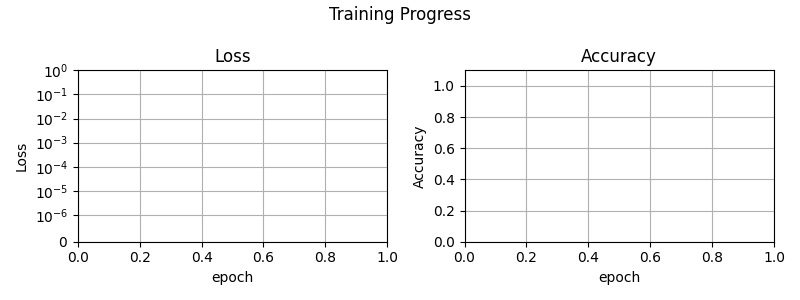

In [38]:
# Realtime training progress (for static-architecture models)
importlib.reload(pm)
if 'static_rtf' in globals():
  plt.close(static_rtf.fig) # Release old figure memory.
static_rtf = pm.RealtimeTrainingFig('epoch')
display(static_rtf.fig.canvas)

In [39]:
# Pause between generating figure and updating it in training loop;
# only necessary when 'run all' is used, otherwise figure is not displayed until training loop finishes.
time.sleep(0.5)

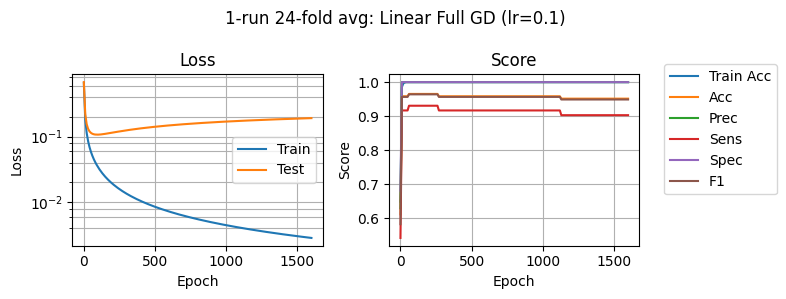

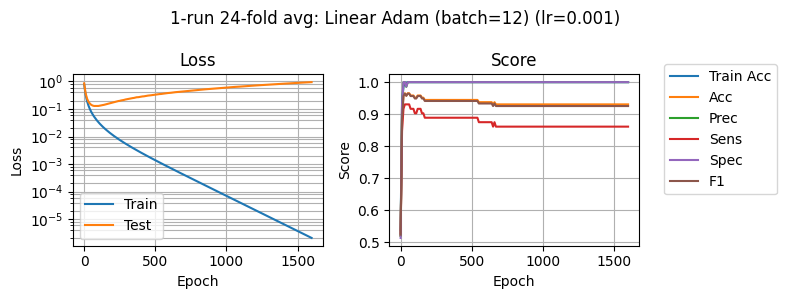

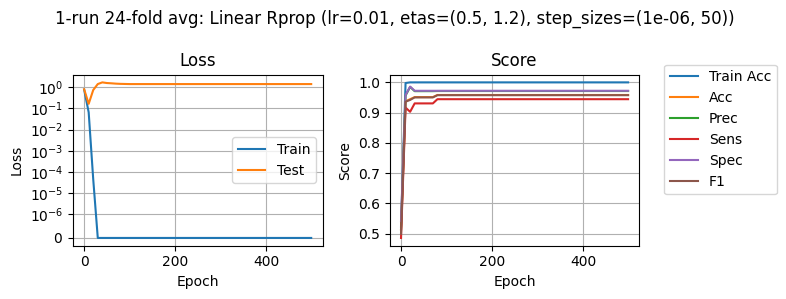

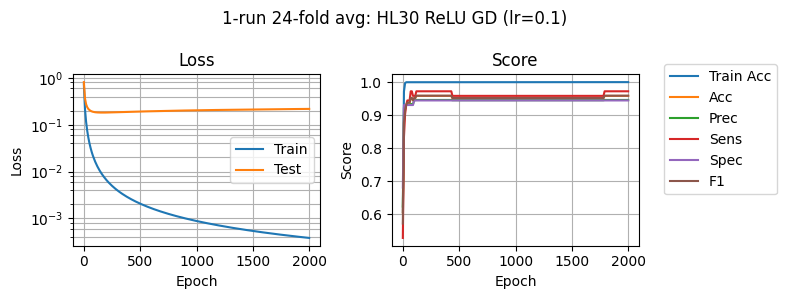

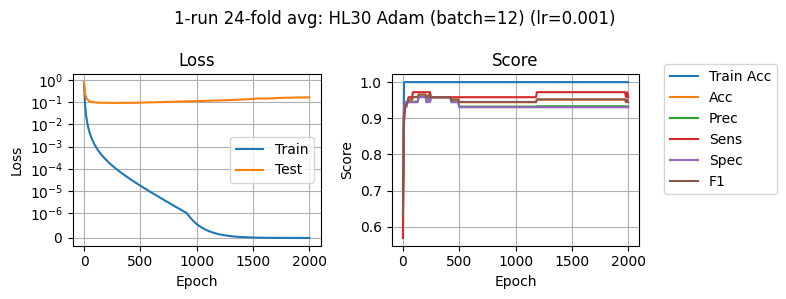

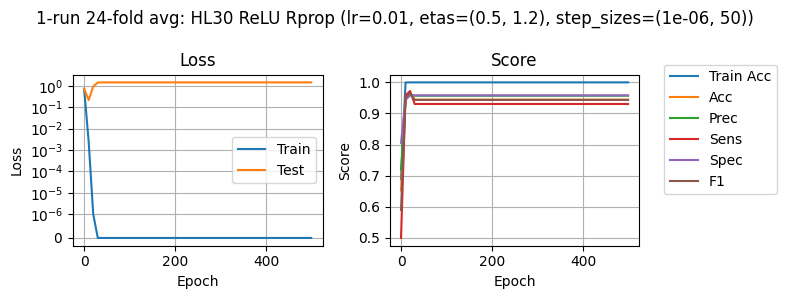

In [40]:
importlib.reload(pm)

record_every = 10 #epochs
dataset = eeg_all # CHANGE TO RUN DIFFERENT DATASETS

# Even when experimenting, we want to use as much training data as possible
# (i.e. leave only one subject out) as this significantly affects the results. 
# However, for speed we can limit the number of folds. Use dataset.n_subjects for final results.
n_folds = dataset.n_subjects
n_runs = 1 # CHANGE TO 5 for paper results

metric_names = ['epoch', 'time', 'train_loss', 'train_accuracy', 'test_loss', 'test_accuracy'] # For tracking training

for M_id, M in staticModels.items():
  # Re-initialise RNG for this model, and generate seeds for each fold/run.
  torch.manual_seed(metaseed)
  M_seeds = torch.randint(2**30, 2**32, (n_runs, n_folds))

  plot_every = max(100, M.n_epochs//10)
  n_records = int(M.n_epochs/record_every) + 1 # Per run and fold

  # Metrics for every record of every fold of every run
  all_confusions = torch.zeros(n_runs, n_folds, n_records, 2, 2) # Test-set confusion matrix
  # Training and test loss/accuracy
  all_metrics = torch.zeros(n_runs, n_folds, n_records, len(metric_names))

  for run_idx in range(n_runs):
    # Clear plot
    static_rtf.reset(M.n_epochs)

    # Leave-one-subject-out cross validation (via kf)
    for fold_idx, (train_idx, test_idx) in enumerate(dataset.split()):
      if fold_idx >= n_folds:
        break

      # Initialise RNG and network for this fold.
      torch.manual_seed(M_seeds[run_idx, fold_idx])
      net = M.initNet(dataset.n_features, **M.net_kw)
      optimiser = M.initOpt(net.parameters(), **M.opt_kw)

      # Batching
      train_loader = DataLoader(dataset, batch_size=M.batch_size,
        drop_last = False, sampler=SubsetRandomSampler(train_idx))

      # Full train/test sets for periodically reporting performance
      trainX, trainY = dataset[train_idx]
      testX, testY = dataset[test_idx]

      # New line on plot
      static_rtf.begin_fold(f"(Run {run_idx+1}/{n_runs}, Fold {fold_idx+1}/{n_folds}) {str(M)}")

      fold_metrics = pm.Metrics(all_metrics[run_idx, fold_idx, :, :], metric_names)

      t0 = time.time() # Start time
      for epoch_idx in range(M.n_epochs):
        for batch_idx, (x, y) in enumerate(train_loader):
          loss = bceLogitLossMean(net(x), y)
          optimiser.zero_grad()
          loss.backward()
          optimiser.step()
        
        # Occasionally record loss and accuracy for training/test sets.
        # Much simpler than computing for every epoch, to avoid interweaving with batching.
        # Assume this consumes negligible time, provided record_every is large.
        if (epoch_idx % record_every == 0) or (epoch_idx == M.n_epochs-1):
          with torch.inference_mode(): # Disables autograd temporarily.
            train_loss, train_acc = loss_accuracy(net(trainX), trainY)
            
            test_logits = net(testX)
            test_loss, test_acc = loss_accuracy(test_logits, testY)
            test_confusion = pm.confusion_matrix(F.sigmoid(test_logits), testY)
            all_confusions[run_idx, fold_idx, fold_metrics.n_rec, :, :] = test_confusion

            fold_metrics.update(epoch_idx, time.time() - t0, train_loss, train_acc, test_loss, test_acc)
        
        # Occasionally update real-time training plot. Blitting (i.e. only 
        # redrawing the data lines) makes this fairly efficient.
        if (epoch_idx % plot_every == 0) or (epoch_idx == M.n_epochs-1):
          static_rtf.update(fold_metrics)
          #print(f"Epoch {epoch_idx}:\n  Train: {train_acc:.3f} accuracy, {train_loss:.3e} loss\n  Test: {test_acc:.3f} accuracy, {test_loss:.3e} loss")
  
  # Compute statistics over all folds/runs
  total_confusion = all_confusions.sum(dim=(0,1)) #(n_records, num_metrics)
  avg_metrics = pm.Metrics(all_metrics.mean(dim=(0,1)), metric_names, n_records)
  # Note data for each fold/run is recorded at same epochs

  # Record performance for this model
  M_perf = pm.KFoldPerformance(total_confusion, avg_metrics, n_folds, n_runs)
  dataset.perfs[M_id] = M_perf
  
  # Plot this model
  fold_fig = M_perf.plot(f"{n_runs}-run {n_folds}-fold avg: {str(M)}")
  display(fold_fig)
  plt.close(fold_fig) # Avoid large memory use from many open figures

dataset.recompute_model_perfs(staticModels.keys()) # just those run above

In [41]:
"""
# For eeg_all dataset with linGD, linAdam and h30Adam: tradeoff between acc/prec/etc. is non-unanimous and made by taking minimum of loss function. Uncomment and run after running these models.

linGDminL, linGDbestIdx = torch.min(eeg_all.perfs['linGDlr0.1'].train_metrics.test_loss, dim=0)

linAdamMinL, linAdamBestIdx = torch.min(eeg_all.perfs['linAdamLr0.001bs12'].train_metrics.test_loss, dim=0)

linAdamBestEpoch = eeg_all.perfs['linAdamLr0.001bs12'].train_metrics.epoch[linAdamBestIdx].item()

linGDbestEpoch = eeg_all.perfs['linGDlr0.1'].train_metrics.epoch[linGDbestIdx].item()

print(linGDminL, linGDbestEpoch)
print(linAdamMinL, linAdamBestEpoch)
"""

"\n# For eeg_all dataset with linGD, linAdam and h30Adam: tradeoff between acc/prec/etc. is non-unanimous and made by taking minimum of loss function. Uncomment and run after running these models.\n\nlinGDminL, linGDbestIdx = torch.min(eeg_all.perfs['linGDlr0.1'].train_metrics.test_loss, dim=0)\n\nlinAdamMinL, linAdamBestIdx = torch.min(eeg_all.perfs['linAdamLr0.001bs12'].train_metrics.test_loss, dim=0)\n\nlinAdamBestEpoch = eeg_all.perfs['linAdamLr0.001bs12'].train_metrics.epoch[linAdamBestIdx].item()\n\nlinGDbestEpoch = eeg_all.perfs['linGDlr0.1'].train_metrics.epoch[linGDbestIdx].item()\n\nprint(linGDminL, linGDbestEpoch)\nprint(linAdamMinL, linAdamBestEpoch)\n"

In [42]:
# eeg_all.recompute_model_perfs(staticModels.keys()) # if needs recomputing

In [43]:
# Show all existing results for all datasets.
# use 'dst' to avoid overwriting dataset variable
for dst in [eeg_all, eeg_no_outliers, eeg_f7]: # also eeg_f3
  print(f"Performance: {dst.name}")
  display(dst.perf_table)

Performance: all


,n_runs,n_folds,epochs,time,size,train-acc,acc,prec,sens,spec,f1
model,,,,,,,,,,,
h30GD,1,24,799.0,4.515297,NaN,1.0,0.951389,0.933333,0.972222,0.930556,0.952381
linGDlr0.1,1,24,140.0,0.123304,NaN,1.0,0.965278,1.000000,0.930556,1.000000,0.964029
linAdamLr0.001bs12,1,24,90.0,0.204294,NaN,1.0,0.958333,1.000000,0.916667,1.000000,0.956522
linRprop,1,24,100.0,0.097409,NaN,1.0,0.958333,0.971429,0.944444,0.972222,0.957746
h30GDlr0.1,1,24,330.0,0.300006,NaN,1.0,0.958333,0.945946,0.972222,0.944444,0.958904
h30AdamBs12,1,24,130.0,0.440034,NaN,1.0,0.958333,0.945946,0.972222,0.944444,0.958904
hid30Rprop,1,24,50.0,0.066969,NaN,1.0,0.944444,0.957143,0.930556,0.958333,0.943662
csp,5,24,60.0,0.165057,0.000,1.0,0.977778,0.967391,0.988889,0.966667,0.978022
cspAdam,5,24,175.0,0.279234,0.425,1.0,0.930556,0.981366,0.877778,0.983333,0.926686


Performance: no_outliers


,n_runs,n_folds,epochs,time,size,train-acc,acc,prec,sens,spec,f1
model,,,,,,,,,,,
linGDlr0.1,5,22,150.0,0.667928,NaN,1.000000,0.978788,1.000000,0.957576,1.000000,0.978328
linSGDlr0.01bs12,1,22,100.0,1.583971,NaN,1.000000,0.977273,1.000000,0.954545,1.000000,0.976744
linAdam,1,22,499.0,2.736360,NaN,1.000000,0.924242,0.982759,0.863636,0.984848,0.919355
linAdamLr0.001bs12,5,22,650.0,7.567780,NaN,1.000000,0.978788,1.000000,0.957576,1.000000,0.978328
linAdamlr0.01,1,22,250.0,1.454465,NaN,1.000000,0.946970,1.000000,0.893939,1.000000,0.944000
linRprop,5,22,50.0,0.270667,NaN,1.000000,0.978788,1.000000,0.957576,1.000000,0.978328
h30GD,1,22,400.0,1.798959,NaN,0.999639,0.977273,0.970149,0.984848,0.969697,0.977444
h30GDlr0.1,5,22,300.0,1.653244,NaN,1.000000,0.978788,0.978788,0.978788,0.978788,0.978788
h30GDlr0.001bs12,1,22,400.0,6.576123,NaN,1.000000,0.977273,0.970149,0.984848,0.969697,0.977444


Performance: f7


,n_runs,n_folds,epochs,time,size,train-acc,acc,prec,sens,spec,f1
model,,,,,,,,,,,
linGDlr0.1,5,22,500.0,2.557012,NaN,1.000000,0.998485,1.000000,0.996970,1.000000,0.998483
linSGDlr0.01bs12,1,22,390.0,4.060837,NaN,0.999278,1.000000,1.000000,1.000000,1.000000,1.000000
linAdam,1,22,499.0,2.196307,NaN,0.785714,0.712121,0.718750,0.696970,0.727273,0.707692
linAdamLr0.001bs12,5,22,670.0,9.790519,NaN,1.000000,0.992424,0.987988,0.996970,0.987879,0.992459
linAdamlr0.01,1,22,400.0,1.808603,NaN,1.000000,0.969697,0.969697,0.969697,0.969697,0.969697
linRprop,5,22,75.0,0.523490,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
h30GD,1,22,799.0,3.597783,NaN,0.988095,0.969697,0.984375,0.954545,0.984848,0.969231
h30GDlr0.1,5,22,999.0,4.708344,NaN,1.000000,0.984848,0.987805,0.981818,0.987879,0.984802
h30GDlr0.001bs12,1,22,799.0,10.685843,NaN,0.990981,0.969697,0.984375,0.954545,0.984848,0.969231


### Train Constructive Cascade Networks

In [44]:
@dataclass
class ConstrCascModel:
  """All ConstrCasc models use same architecture, so just specify training mechanism"""
  desc: str

  initNet: nn.Module # will be passed (trainX, **net_kw)
  net_kw: dict
  initOpt: torch.optim.Optimizer # passed (net.get_parameters(), **opt_kw)
  opt_kw: dict
  
  generate_neuron: any
  train_period: any
  # and kwargs for each?

  k: float = 0.0 # Weight-decay constant

  n_epochs: int = 1500

  performance: pm.KFoldPerformance = None

  def __str__(self):
    return f"{self.desc} ({', '.join([f'{k}={v}' for k,v in self.opt_kw.items()])})"

  def clone(self, **kwargs):
    return dataclasses.replace(self,**kwargs)

In [45]:
# Manually-identified best epochs to evaluate at, for Casper models.
eeg_no_outliers.eval_epochs.update({
  'csp': 70,
  'cspAdam': 1000,
  'cspGD': 500
})

eeg_all.eval_epochs.update({
  'csp': 60,
  'cspAdam': 175,
  'cspGD': 750
})

eeg_f7.eval_epochs.update({
  'csp': 100,
  'cspAdam': 300,
  'cspGD': 750
})

In [46]:
# Weight variability for candidates
# ** WHEN to add a new neuron

importlib.reload(constr_casc)
Casper = constr_casc.Casper
#Cascor = constr_casc.Cascor

# For casper models, optimiser lr is specified by L1,L2,L3 (not opt_kw)

# Base models
casper = ConstrCascModel("Casper Original",
    Casper, {'L1': 0.2, 'L2': 0.005, 'L3': 0.001},
    Rprop, {'etas':(0.5, 1.2), 'step_sizes':(1e-06, 50)},
    lambda net: net.gen_neuron(), lambda net: 15 * (1.5**net.H), k=0)

constrCascModels = {
  #'cspWD': casper.clone(desc="Casper WD", k=0.005),
  'csp': casper,
  #'cspAdamW': casper.clone(initOpt=torch.optim.AdamW, desc="Casper AdamW",opt_kw={'weight_decay': 0.005}, n_epochs = 3000),
  'cspAdam': casper.clone(initOpt=Adam, desc="Casper Adam",opt_kw={},
    net_kw={'L1': 0.01, 'L2': 0.003, 'L3': 0.0001}, n_epochs = 3000),
  'cspGD': casper.clone(initOpt=SGD, opt_kw={}, desc="Casper GD",
    net_kw={'L1': 0.1, 'L2': 0.01, 'L3': 0.001}, n_epochs = 3000),
}

improve_thresh = 0.02 # 2% improvement

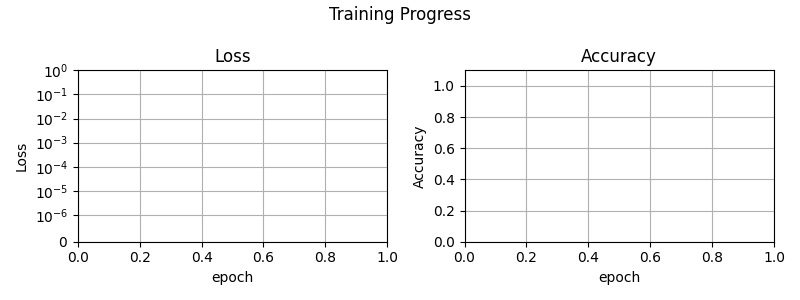

In [47]:
# Set up real-time training plot
importlib.reload(pm)
if 'cc_rtf' in globals():
  plt.close(cc_rtf.fig) # Release old figure memory.
cc_rtf = pm.RealtimeTrainingFig('epoch')
display(cc_rtf.fig.canvas)

In [48]:
time.sleep(0.5) # In case 'run all' is used; need a delay between generating and updating figure.

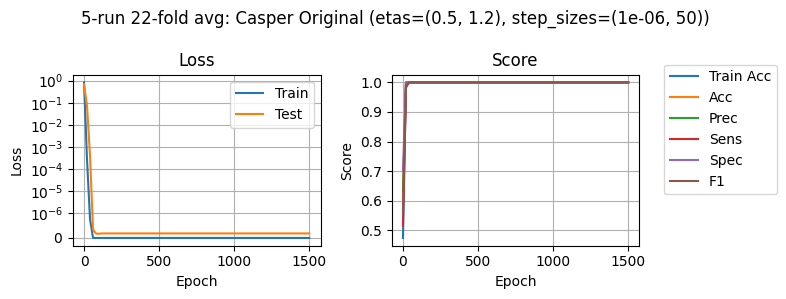

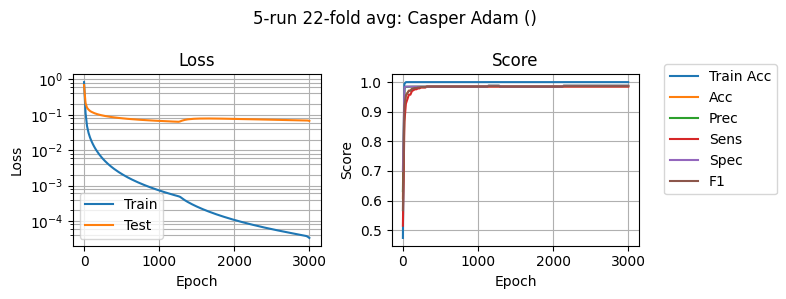

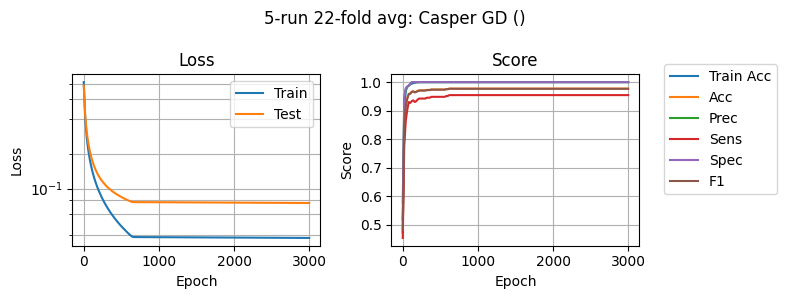

In [49]:
record_every = 20 # epochs
dataset = eeg_f7
n_folds = dataset.n_subjects #for final results
n_runs = 5

metric_names = ['epoch', 'time', 'train_loss', 'train_accuracy', 'test_loss', 'test_accuracy', 'hidden_neurons']

for M_id, M in constrCascModels.items():
  # Re-initialise RNG for this model, and generate seeds for each fold/run.
  torch.manual_seed(metaseed)
  M_seeds = torch.randint(2**30, 2**32, (n_runs, n_folds))

  plot_every = max(100, M.n_epochs//10)
  n_records = int(M.n_epochs/record_every) + 1 # Per run and fold

  # Metrics for every record of every fold of every run
  all_confusions = torch.zeros(n_runs, n_folds, n_records, 2, 2)
  all_metrics = torch.zeros(n_runs, n_folds, n_records, len(metric_names))

  for run_idx in range(n_runs):
    cc_rtf.reset(M.n_epochs)
    # Leave-one-subject-out cross validation (via kf)
    for fold_idx, (train_idx, test_idx) in enumerate(dataset.split()):
      if fold_idx >= n_folds:
        break
      # No need for dataloader here, since no batching.
      trainX, trainY = dataset[train_idx]
      testX, testY = dataset[test_idx]

      # Initialise network for this fold.
      torch.manual_seed(M_seeds[run_idx, fold_idx])
      stage_rng = torch.Generator() # So that each 'stage' has same neurons added, even if they last different numbers of periods for different models
      net = M.initNet(trainX)
      param_groups = net.get_parameters()
      optimiser = M.initOpt(param_groups, **M.opt_kw)
      # Optimiser will be overwritten each time a new neuron is added.
      # If M.opt_kw specifies lr, this will be overwritten by individual
      # parameter groups in net.get_parameters().
      params = [p for group in param_groups for p in group['params']]

      # Plotting
      cc_rtf.begin_fold(f"(Run {run_idx+1}/{n_runs}, Fold {fold_idx+1}/{n_folds}) {str(M)}")
      fold_metrics = pm.Metrics(all_metrics[run_idx, fold_idx, :, :], metric_names)

      # Initial error and final epoch of current stage (err not actually rms)
      rms_err_prev = bceLogitLossMean(net.compute_output(), trainY).item()
      period_epoch_max = M.train_period(net)
      hepoch = 0 # Epochs since last hidden neuron

      # Training loop
      t0 = time.time() # Start time
      for epoch_idx in range(M.n_epochs):
        # Train using optimiser.
        # For Casper, this trains the whole network.
        # For Cascor, this trains the output layer only.
        pred_logits = net.compute_output()
        train_loss = bceLogitLossMean(pred_logits, trainY)
        optimiser.zero_grad()
        train_loss.backward() # TODO: inputs=... to avoid computing unnecessary gradients.

        # Apply weight decay
        if M.k != 0.0:
          for p in params:
            p.grad -= M.k * torch.sign(p) * (p**2) * (0.5**(0.01*hepoch))

        # Update weights
        optimiser.step()

        # Occasionally record loss and accuracy for training/test sets.
        if (epoch_idx % record_every == 0) or (epoch_idx == M.n_epochs-1):
          with torch.inference_mode(): # Disables autograd temporarily.
            train_pred = F.sigmoid(pred_logits).round()
            train_acc = torch.mean(train_pred == trainY, dtype=torch.float32).item()
            test_logits = net(testX) # .compute_output() is only for training data
            test_loss, test_acc = loss_accuracy(test_logits, testY)
            test_confusion = pm.confusion_matrix(F.sigmoid(test_logits), testY)

            all_confusions[run_idx, fold_idx, fold_metrics.n_rec,:,:] = test_confusion
            fold_metrics.update(epoch_idx, time.time()-t0, train_loss, train_acc, test_loss, test_acc, net.H)
        
        # Update plot occasionally
        if (epoch_idx % plot_every == 0) or (epoch_idx == M.n_epochs-1):
          cc_rtf.update(fold_metrics)
        
        # Check if it's time to end
        hepoch += 1
        #if epoch_idx >= M.n_epochs-1:
        #  break
        if epoch_idx >= period_epoch_max: # or check if need new neuron?
          # Add new neuron if needed (i.e. start new stage).
          # Skip if train_loss < 1e-7, to avoid adding copious neurons
          rms_err = train_loss
          if (rms_err > 1e-7) and (rms_err_prev - rms_err) / rms_err_prev < improve_thresh:
            # Nice edge case: rms_err_prev=0 -> NaN !< 0 -> False
            # Set seed for this stage, using stage_rng
            torch.manual_seed(
              torch.randint(2**30, 2**32, (1,), generator=stage_rng).item()
            )
            net.add_neuron(M.generate_neuron(net)) # For Cascor, this would take time (which should count as epochs, but don't right now)
            optimiser = M.initOpt(net.get_parameters(), **M.opt_kw)
            hepoch = 0
          # Either way, update err_prev and period_epoch_max
          rms_err_prev = rms_err
          period_epoch_max = epoch_idx + M.train_period(net)
  
  # Compute statistics over all folds/runs
  total_confusion = all_confusions.sum(dim=(0,1)) #(n_records, num_metrics)
  avg_metrics = pm.Metrics(all_metrics.mean(dim=(0,1)), metric_names, n_records)

  # Record performance for this model
  M_perf = pm.KFoldPerformance(total_confusion, avg_metrics, n_folds, n_runs)
  dataset.perfs[M_id] = M_perf
  
  # Plot this model
  fold_fig = M_perf.plot(f"{n_runs}-run {n_folds}-fold avg: {str(M)}")
  display(fold_fig)
  plt.close(fold_fig) # Avoid large memory use from many open figures

dataset.recompute_model_perfs(constrCascModels.keys())

In [50]:
"""
cspGDMin, cspGDBestIdx = torch.min(eeg_all.perfs['cspGD'].train_metrics.test_loss, dim=0)

cspGDBestEpoch = eeg_all.perfs['cspGD'].train_metrics.epoch[cspGDBestIdx].item()

print(cspGDMin, cspGDBestEpoch)
"""

"\ncspGDMin, cspGDBestIdx = torch.min(eeg_all.perfs['cspGD'].train_metrics.test_loss, dim=0)\n\ncspGDBestEpoch = eeg_all.perfs['cspGD'].train_metrics.epoch[cspGDBestIdx].item()\n\nprint(cspGDMin, cspGDBestEpoch)\n"

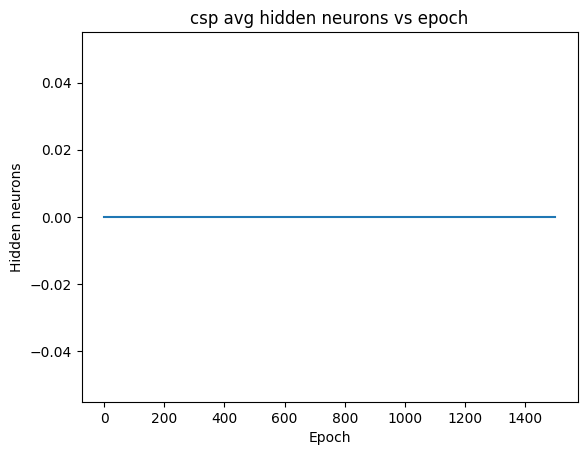

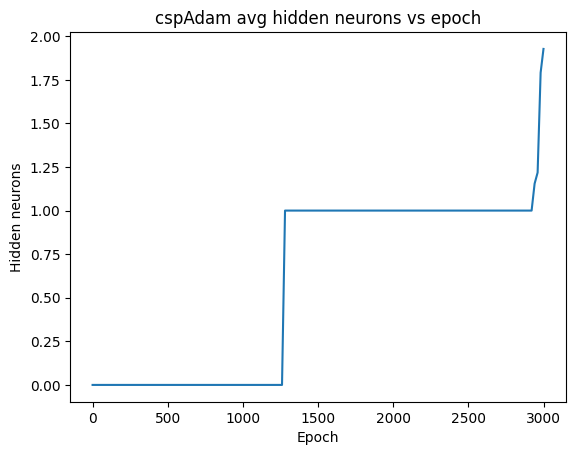

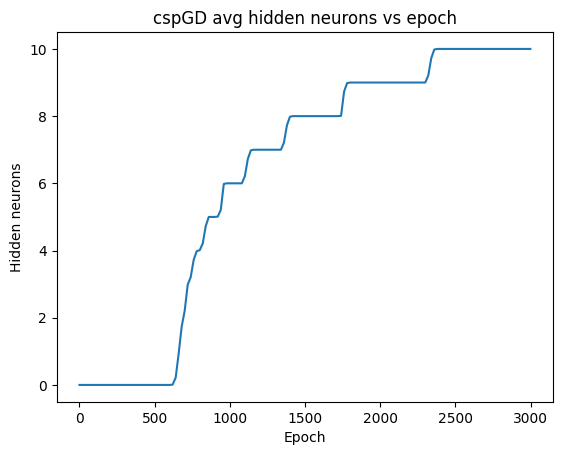

In [51]:
# Plot size vs epoch for each constrCasc model
dst = dataset
for M_id, M in constrCascModels.items():
  M_perf = dst.perfs[M_id]
  fig, ax = plt.subplots()
  ax.plot(M_perf.train_metrics.epoch, M_perf.train_metrics.hidden_neurons)
  ax.set_title(f"{M_id} avg hidden neurons vs epoch")
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Hidden neurons")
  display(fig)
  plt.close(fig)